In [ ]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import warnings
import random
from keras.datasets import fashion_mnist
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from scipy.optimize import check_grad

# Task 1: Acquire the data

In [ ]:
# load the data
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
class_names = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(trainX.shape)
print(trainy.shape)
print(testX.shape)
print(testy.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


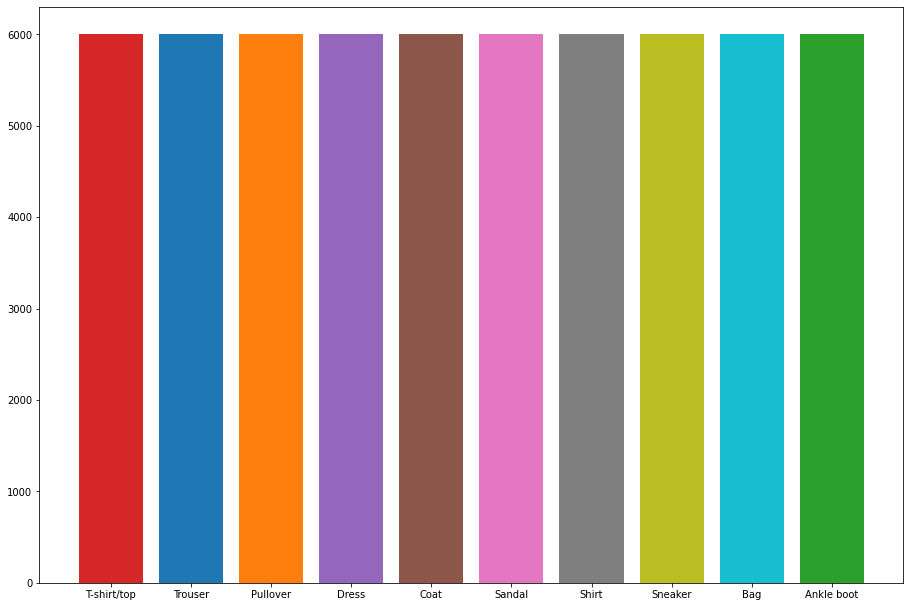

In [ ]:
obj = class_names.values()
dic = {}
for i in range(10):
  name = class_names[i]
  dic[name] = np.count_nonzero(trainy == i)
bar_color = ['tab:red','tab:blue','tab:orange','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','tab:green']
label = obj
fig,ax = plt.subplots()
ax = fig.add_axes([0,0,2,2])
values = dic.values()
ax.bar(label,values, color = bar_color)
plt.show()

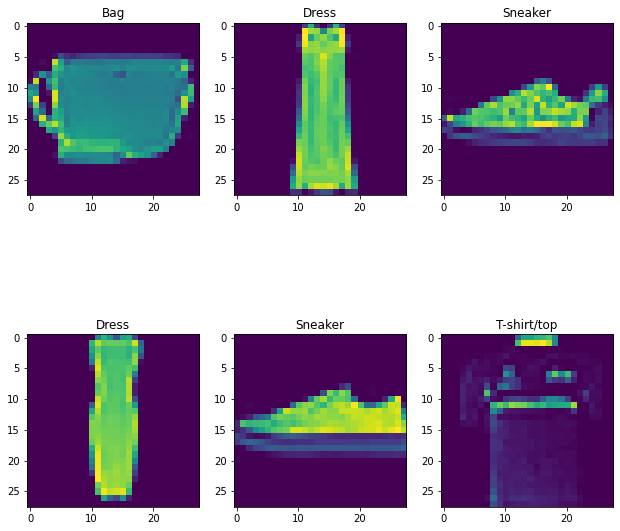

In [ ]:
# visualize the data, we randomly pick 6 images in the training set
f, axes = plt.subplots(2,3)
f.set_size_inches(10.5, 10.5)
for row in axes:
    for axe in row:
        index = np.random.randint(10000)
        img = trainX[index]
        obj = trainy[index]
        axe.imshow(img)
        axe.set_title(class_names[obj])

In [ ]:
# reshape the data
X_train = trainX.reshape((trainX.shape[0], 28*28)).astype('float32')
X_test = testX.reshape((testX.shape[0], 28*28)).astype('float32')

In [ ]:
# normalization 
def standardization(matrix):
  # first subtract the mean to make the data zero-centered
  matrix -= np.mean(matrix, axis = 0)
  # once the data is zero-centered, we divide each dimension by its std
  matrix /= np.std(matrix, axis = 0)
  return matrix

X_unnormalized = X_train.copy()
X_train = standardization(X_train)
X_test = standardization(X_test)

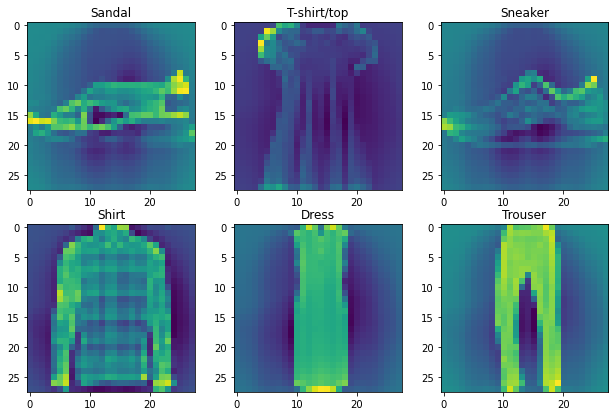

In [ ]:
# visualization of the data after standarization, we randomly pick 6 images
plt.figure(figsize=(10.5, 10.5))
index = np.random.choice(60000,6)
for i in range(len(index)):
  plt.subplot(3, 3, i+1)
  classes = trainy[index[i]]
  label = class_names[classes]
  img = X_train[index[i]].reshape(28,28)
  plt.imshow(img)
  plt.title(label)
plt.show()

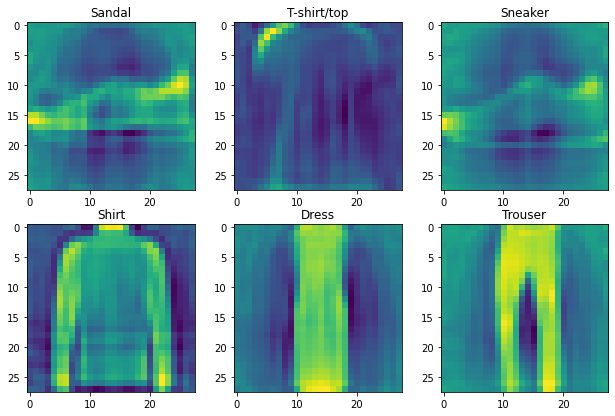

In [ ]:
# PCA
def PCA(X):
  # compute the covariance matrix that tells about the correlation stucture
  cov = np.dot(X.T, X)/ X.shape[0]
  # compute the SVD factorization of the data covariance matrix
  U,S,V = np.linalg.svd(cov)
  # to decorrelate the data, we project the origin data into eignbasis
  Xrot = np.dot(X,U)
  # reduce the original dataset N*D to one of size N*100
  Xrot_reduced = np.dot(X, U[:,:100])
  X_invert = np.dot(Xrot_reduced, U[:,:100].T)
  return X_invert

X_train_pca = PCA(X_train)
X_test_pca = PCA(X_test)

# visualize the data after PCA process
plt.figure(figsize=(10.5, 10.5))
for i in range(len(index)):
  plt.subplot(3, 3, i+1)
  classes = trainy[index[i]]
  label = class_names[classes]
  img = X_train_pca[index[i]].reshape(28,28)
  plt.imshow(img)
  plt.title(label)
plt.show()

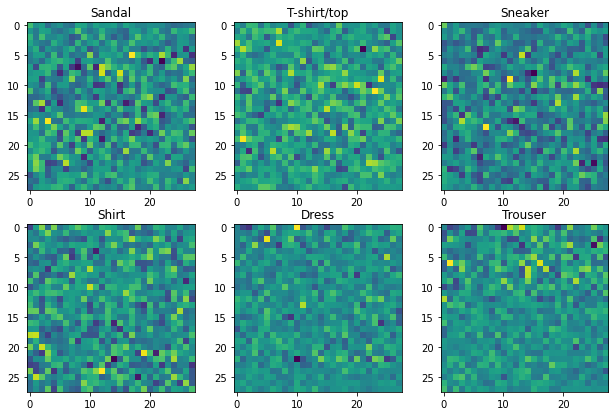

In [ ]:
# whitening
def whitening(X):
  # compute the covariance matrix that tells about the correlation stucture
  cov = np.dot(X.T, X)/ X.shape[0]
  # compute the SVD factorization of the data covariance matrix
  U,S,V = np.linalg.svd(cov)
  # to decorrelate the data, we project the origin data into eignbasis
  Xrot = np.dot(X,U)
  # divide by the eigenvalues (which are square roots of the singular values)
  Xwhite = Xrot/np.sqrt(S+1e-5)
  return Xwhite

X_train_white = whitening(X_train)
X_test_white = whitening(X_test)

# visualize the data after whitening process
plt.figure(figsize=(10.5, 10.5))
for i in range(len(index)):
  plt.subplot(3, 3, i+1)
  classes = trainy[index[i]]
  label = class_names[classes]
  img = X_train_white[index[i]].reshape(28,28)
  plt.imshow(img)
  plt.title(label)
plt.show()

In [ ]:
y_test = testy.flatten()
y_train = trainy.flatten()

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


# Task 2: Implement an MLP to classify image data

## Activation Functions

In [ ]:
class Logistic:
  def activate(input):
    return 1./ (1 + np.exp(-input))
  def derivative(output):
    return output*(1-output)

In [ ]:
class Relu:
  def activate(input):
    return np.maximum(input,0)
  def derivative(output):
    return (output>0)*1

In [ ]:
class LeakyRelu:
  def activate(input, alpha = 0.01):
    result = np.maximum(input,0)+ alpha * np.minimum(input, 0)
    return result
  def derivative(output, alpha = 0.01):
    first = (output>0)*1
    second = (output<0)*alpha
    return first+second


In [ ]:
class Tanh:
  def activate(input):
    top = np.exp(input)-np.exp(-input)
    bottom = np.exp(input)+np.exp(-input)
    return top/bottom
  def derivative(output):
    tanh_square = Tanh.activate(output)**2
    return 1-tanh_square

In [ ]:
class ExpLinearUnit:
  def activate(input, alpha = 0.01):
    first = np.maximum(input, 0)
    second = np.minimum(alpha*(np.exp(input)-1), 0)
    return first + second
  def derivative(output, alpha = 0.01):
    first = (output>0)*1
    second_p = ((alpha*(np.exp(output)-1))<0)*1
    return first + second_p * alpha * np.exp(output)

## Util Functions

In [ ]:
D = X_train.shape[1]
C = len(class_names.keys())

def eval_acc(y, y_pred):
  return np.sum(y == y_pred, dtype=int) / y_pred.shape[0]

def one_hot_encoding(vector):
  targets = np.array(vector).reshape(-1)
  return np.eye(C)[targets]

def softmax(x):
  exps = np.exp(x -  np.max(x, axis=1)[:,None])
  probs = exps / np.sum(exps, axis=-1)[:, None]
  return probs

def mini_batch(x, y, batchsize):
  index = np.arange(x.shape[0])
  random.shuffle(index)
  for num in range(0, x.shape[0], batchsize):
    indices = index[num:(num+batchsize)]
    yield x[indices], y[indices]

## MLP Implementation

In [ ]:
class MLP:

  def __init__(self, act, num_hidden_layer = 2, num_units = [64, 64], l2_reg = 0):
    self.act = act
    self.num_hidden_layer = num_hidden_layer
    self.num_units = num_units
    self.l2_reg = l2_reg
    self.w = []
    self.b = []
    # initialize weight and bias for each layer
    all_units = [D] + self.num_units + [C]
    for layer in range(num_hidden_layer + 1):
      self.w.append(np.random.randn(all_units[layer], all_units[layer+1]) * 0.01)
      self.b.append(np.zeros((all_units[layer+1], 1)))

  def train(self, X, y, optimizer, epoch=100, batch_size=32, \
            plot=True, X_test=None, y_test=None, is_val=False):
    label = "validation" if is_val else "test"
    acc_train = []
    acc_test = []

    for i in range(epoch):
      for Xb, yb in mini_batch(X, y, batch_size):
        self.fit(Xb, yb, optimizer)
      
      if plot:
        y_pred_train = self.predict(X)
        y_pred_test = self.predict(X_test)
        acc_train.append(eval_acc(y, y_pred_train))
        acc_test.append(eval_acc(y_test, y_pred_test))
        if i % 20 == 0:
          print(f"Epoch {i}, {label} accuracy = {acc_test[-1]}")
    
    if plot:
      plt.clf()
      plt.plot(acc_train, label="train")
      plt.plot(acc_test, label=label)
      plt.ylabel("Accuracy")
      plt.xlabel("Epoch")
      plt.title("Accuracy as a function of epoch")
      plt.legend()
      plt.show()
    
    if not plot:
      y_pred_test = self.predict(X_test)
      acc_test.append(eval_acc(y_test, y_pred_test))
    print(f"Finished in {epoch} epochs, final {label} accuracy = {acc_test[-1]}")
    return acc_test[-1]

  def fit(self, X, y, optimizer):
    N = X.shape[0]
    y = one_hot_encoding(y)

    def gradient(X, y, w, b):
      z = [X]
      # forward pass
      for i in range(1, self.num_hidden_layer + 2):
        if (i == self.num_hidden_layer+1):
          z.append(softmax(np.dot(z[i-1], w[i-1]) + b[i-1].T))
        else:
          z.append(self.act.activate(np.dot(z[i-1], w[i-1]) + b[i-1].T))

      dw, dz, db = [], [], []
      # backpropogate from output to hidden layer
      dz.append(z[-1] - y)
      grad = np.dot(z[-2].T, dz[0])
      if self.l2_reg != 0:
        grad = grad + self.l2_reg * w[-1]
      dw.append(grad / N)
      db.append(np.sum(dz[0], axis=0, keepdims=True) / N)

      ct = 1
      # backpropogate through all hidden layers
      for i in reversed(range(1, self.num_hidden_layer + 1)):
        dz.append(np.dot(dz[ct-1], w[i].T))
        grad = np.dot(z[i-1].T,dz[ct] * self.act.derivative(z[i]))
        if self.l2_reg != 0:
          grad = grad + self.l2_reg * w[i-1]
        dw.append(grad / N)
        db.append(np.sum(dz[ct] * self.act.derivative(z[i]), axis=0, keepdims=True) / N)
        ct += 1

      dw.reverse()
      db.reverse()
      return dw, db
    
    self.w, self.b = optimizer.run(gradient, X, y, self.w, self.b)
    return self

  def predict(self, X):
    z = X
    for i in range(1, self.num_hidden_layer + 2):
      if (i == self.num_hidden_layer+1):
        z = softmax(np.dot(z, self.w[i-1])+self.b[i-1].T)
        yh = np.argmax(z, axis=1).astype(int)
        return yh
      else:
        z = self.act.activate(np.dot(z, self.w[i-1])+self.b[i-1].T)

## Gradient Descent Optimizer

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, w, b):
        grad_w, grad_b = gradient_fn(x, y, w, b)
        for p in range(len(w)):
            w[p] -= self.learning_rate * grad_w[p]
            b[p] -= self.learning_rate * grad_b[p].T
        return w, b

# Task 3: Run experiments

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=42)

## (Extra) Hyperparameter tuning: Batch size, Learning rate, and λ for L2-norm

1. Batch size

Batch size: 32
-Finished in 50 epochs, final validation accuracy = 0.8882222222222222
Batch size: 64
-Finished in 50 epochs, final validation accuracy = 0.8868888888888888
Batch size: 200
-Finished in 50 epochs, final validation accuracy = 0.8917222222222222
Batch size: 500
-Finished in 50 epochs, final validation accuracy = 0.8832222222222222
Batch size: 1000
-Finished in 50 epochs, final validation accuracy = 0.8781666666666667
Batch size: 1500
-Finished in 50 epochs, final validation accuracy = 0.8714444444444445
Batch size: 2000
-Finished in 50 epochs, final validation accuracy = 0.8635555555555555


Text(0, 0.5, 'Validation Accuracy')

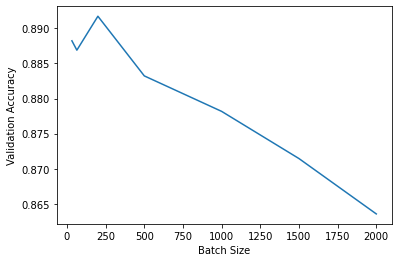

In [ ]:
optimizer = GradientDescent(learning_rate=.05)
acc_batch = []
batch_sizes = [32, 64, 200, 500, 1000, 1500, 2000]
for b in batch_sizes:
  model = MLP(act=Relu, num_hidden_layer=1, num_units=[128])
  print(f"Batch size: {str(b)}", end="\n-")
  acc_batch.append(model.train(X_train, y_train, optimizer, epoch=50, batch_size=b, X_test=X_val, y_test=y_val, plot=False, is_val=True))
plt.plot(batch_sizes, acc_batch)
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')

2. Learning rate

------------Learning rate: 0.025------------
Epoch 0, validation accuracy = 0.7541666666666667
Epoch 20, validation accuracy = 0.8775555555555555
Epoch 40, validation accuracy = 0.8842777777777778


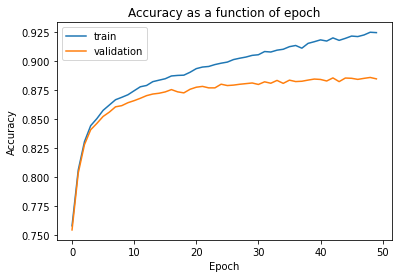

Finished in 50 epochs, final validation accuracy = 0.8847777777777778
------------Learning rate: 0.05------------
Epoch 0, validation accuracy = 0.7991111111111111
Epoch 20, validation accuracy = 0.8828333333333334
Epoch 40, validation accuracy = 0.8883333333333333


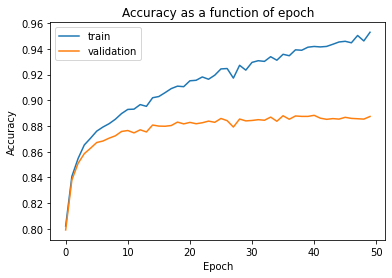

Finished in 50 epochs, final validation accuracy = 0.8874444444444445
------------Learning rate: 0.1------------
Epoch 0, validation accuracy = 0.8381666666666666
Epoch 20, validation accuracy = 0.8868333333333334
Epoch 40, validation accuracy = 0.8835555555555555


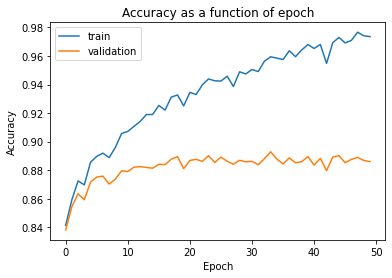

Finished in 50 epochs, final validation accuracy = 0.886
------------Learning rate: 0.25------------
Epoch 0, validation accuracy = 0.8433888888888889
Epoch 20, validation accuracy = 0.8883333333333333
Epoch 40, validation accuracy = 0.8855555555555555


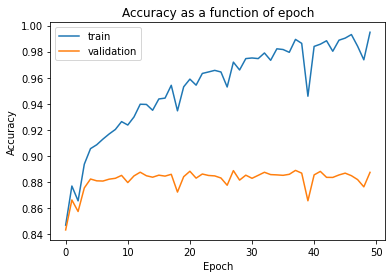

Finished in 50 epochs, final validation accuracy = 0.8875


In [ ]:
lrs = [0.025, 0.05, 0.1, 0.25]
for lr in lrs:
  optimizer_lr = GradientDescent(learning_rate=lr)
  model = MLP(act=Relu, num_hidden_layer=1, num_units=[128])
  print(f"------------Learning rate: {str(lr)}------------")
  model.train(X_train, y_train, optimizer_lr, epoch=50, batch_size=200, X_test=X_val, y_test=y_val, is_val=True)

3. λ for L2-norm

In [ ]:
optimizer = GradientDescent(learning_rate=.025)
l2 = [0.2, 0.5, 1, 5, 10]
for l2_reg in l2:
  model2 = MLP(act=Relu, num_hidden_layer=2, num_units=[128, 128], l2_reg = l2_reg)
  print(f"------------Lambda: {str(l2_reg)}------------")
  model2.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_val, y_test=y_val, is_val=True, plot = False)

------------Lambda: 0.2------------
Finished in 50 epochs, final validation accuracy = 0.8851111111111111
------------Lambda: 0.5------------
Finished in 50 epochs, final validation accuracy = 0.8843888888888889
------------Lambda: 1------------
Finished in 50 epochs, final validation accuracy = 0.8851666666666667
------------Lambda: 5------------
Finished in 50 epochs, final validation accuracy = 0.8501111111111112
------------Lambda: 10------------
Finished in 50 epochs, final validation accuracy = 0.8249444444444445


## Compare models with different numbers of hidden layers & Add L2-Regularization

(1) an MLP with no hidden layer

Epoch 0, test accuracy = 0.8156
Epoch 20, test accuracy = 0.8429
Epoch 40, test accuracy = 0.843


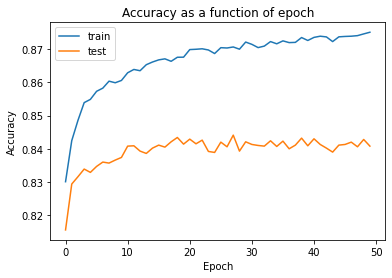

Finished in 50 epochs, final test accuracy = 0.8408


In [ ]:
optimizer = GradientDescent(learning_rate=.025)
model0 = MLP(act=None, num_hidden_layer=0, num_units=[])
model0.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test)

(2) an MLP with a single hidden layer having 128 units and ReLU activations

Epoch 0, test accuracy = 0.7463
Epoch 20, test accuracy = 0.8659
Epoch 40, test accuracy = 0.8735


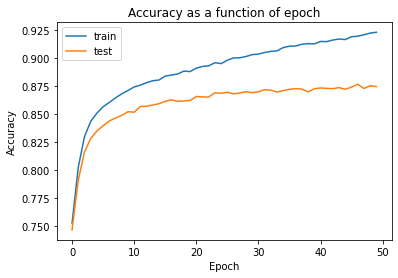

Finished in 50 epochs, final test accuracy = 0.8747


In [ ]:
model1 = MLP(act=Relu, num_hidden_layer=1, num_units=[128])
model1.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test)

(3) an MLP with 2 hidden layers each having 128 units with ReLU activations with/without L2 regularization

Epoch 0, test accuracy = 0.3583
Epoch 20, test accuracy = 0.8618
Epoch 40, test accuracy = 0.8759


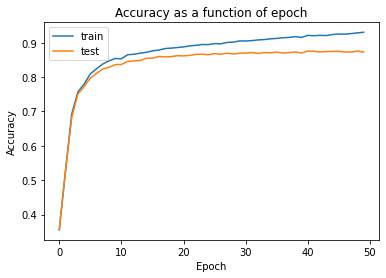

Finished in 50 epochs, final test accuracy = 0.8731


In [ ]:
model2_without = MLP(act=Relu, num_hidden_layer=2, num_units=[128, 128])
model2_without.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test)

Epoch 0, test accuracy = 0.3773
Epoch 20, test accuracy = 0.8578
Epoch 40, test accuracy = 0.8706


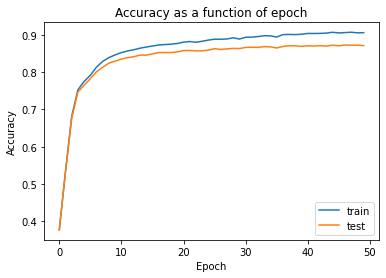

Finished in 50 epochs, final test accuracy = 0.8711


In [ ]:
model2_with = MLP(act=Relu, num_hidden_layer=2, num_units=[128, 128], l2_reg = 1)
model2_with.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test)

(4) (Extra) an MLP with 4 hidden layers each having 128 units with ReLU activations

Epoch 0, test accuracy = 0.1
Epoch 20, test accuracy = 0.1
Epoch 40, test accuracy = 0.1997
Epoch 60, test accuracy = 0.8071
Epoch 80, test accuracy = 0.8543


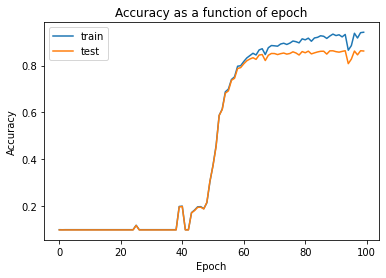

Finished in 100 epochs, final test accuracy = 0.8617


0.8617

In [ ]:
optimizer = GradientDescent(learning_rate=.025)
model4 = MLP(act=Relu, num_hidden_layer=4, num_units=[128, 128, 128, 128])
model4.train(X_train, y_train, optimizer, epoch=100, batch_size=200, X_test=X_test, y_test=y_test)

## Model with 2 hidden layers and different activation functions

Functions to try out:
1. Tanh
2. Leaky-Relu
3. (Extra) Logistic 
4. (Extra) ELU

In [ ]:
func = [Tanh, LeakyRelu, Logistic, ExpLinearUnit]
for f in func:
  model = MLP(act=f, num_hidden_layer=2, num_units=[128, 128])
  print("Activation Function: " + f.__name__, end="\n-")
  model.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test, plot=False)

Activation Function: Tanh
-Finished in 50 epochs, final test accuracy = 0.8658
Activation Function: LeakyRelu
-Finished in 50 epochs, final test accuracy = 0.8748
Activation Function: Logistic
-Finished in 50 epochs, final test accuracy = 0.8337
Activation Function: ExpLinearUnit
-Finished in 50 epochs, final test accuracy = 0.8753


## Train with unnormalized images

In [ ]:
model = MLP(act=Relu, num_hidden_layer=2, num_units=[128, 128])
model.train(X_unnormalized, trainy, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test, plot=False)

Finished in 50 epochs, final test accuracy = 0.0504


0.0504

Using the same activation function and the same hyperparameters, the accuracy we get from normalized data was 0.8731.

## Convolutional Neural Network (ConvNet) with 2 convolutional and 2 fully connected layers

In [ ]:
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
x_train = (trainX / 255) - 0.5
x_test = (testX / 255) - 0.5

x_train = np.expand_dims(x_train, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)

ytrain = one_hot_encoding(trainy.flatten())
ytest = one_hot_encoding(y_test)

In [ ]:
num_filter = 8
filter_size = 3
pool_size = 2
num_classes = 10
batch_size = 64
input_shape = x_train.shape[1:]
strides = 1 
model = Sequential([
    Conv2D(4 * num_filter, filter_size, strides = strides, input_shape = (28, 28, 1), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = pool_size),
    Conv2D(8 * num_filter, kernel_size = (filter_size, filter_size), activation = 'relu'),
    MaxPooling2D(pool_size = (pool_size, pool_size)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(num_classes, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
model.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
epochs = 20

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
image_train, xval, label_train, yval = train_test_split(x_train, ytrain, test_size=0.3, shuffle=True, random_state=42)
# Fitting the model
history = model.fit(
  image_train,
  label_train, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(xval, yval), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/20
656/657 [============================>.] - ETA: 0s - loss: 0.5081 - accuracy: 0.8145
Epoch 1: val_loss improved from inf to 0.36241, saving model to best_model.hdf5
657/657 [==============================] - 51s 76ms/step - loss: 0.5081 - accuracy: 0.8145 - val_loss: 0.3624 - val_accuracy: 0.8659
Epoch 2/20
656/657 [============================>.] - ETA: 0s - loss: 0.3185 - accuracy: 0.8830
Epoch 2: val_loss improved from 0.36241 to 0.30348, saving model to best_model.hdf5
657/657 [==============================] - 47s 72ms/step - loss: 0.3184 - accuracy: 0.8830 - val_loss: 0.3035 - val_accuracy: 0.8871
Epoch 3/20
656/657 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.9013
Epoch 3: val_loss improved from 0.30348 to 0.27123, saving model to best_model.hdf5
657/657 [==============================] - 51s 77ms/step - loss: 0.2690 - accuracy: 0.9014 - val_loss: 0.2712 - val_accuracy: 0.9011
Epoch 4/20
656/657 [============================>.] - ETA: 0s - l

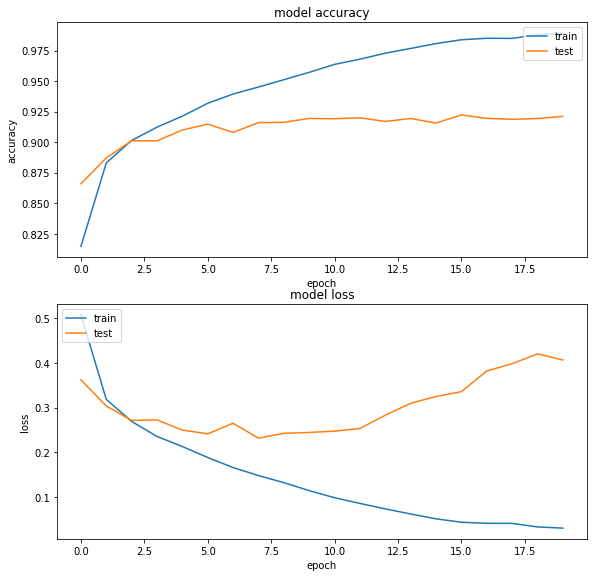

In [ ]:
# plot training history
plt.figure(figsize=(9.5,9.5))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_predictions = model.predict(x_test)
correct = np.sum(test_predictions == ytest)
error = 100.0 - (100 * float(correct)/float(test_predictions.shape[0]))
print('Test error: %.1f%%' % error)

313/313 [==============================] - 4s 11ms/step
Test error: 96.6%


## (Extra) MLP with a different type of activation function on each layer

In [ ]:
class MLPV2:

  def __init__(self, acts = [Relu, Relu], num_hidden_layer = 2, num_units = [64, 64]):
    self.acts = acts
    self.num_hidden_layer = num_hidden_layer
    self.num_units = num_units
    self.w = []
    self.b = []
    # initialize weight and bias for each layer
    all_units = [D] + self.num_units + [C]
    for layer in range(num_hidden_layer + 1):
      self.w.append(np.random.randn(all_units[layer], all_units[layer+1]) * 0.01)
      self.b.append(np.zeros((all_units[layer+1], 1)))

  def train(self, X, y, optimizer, epoch=100, batch_size=32, \
            plot=True, X_test=None, y_test=None):
    acc_train = []
    acc_test = []

    for i in range(epoch):
      for Xb, yb in mini_batch(X, y, batch_size):
        self.fit(Xb, yb, optimizer)
      
      if plot:
        y_pred_train = self.predict(X)
        y_pred_test = self.predict(X_test)
        acc_train.append(eval_acc(y, y_pred_train))
        acc_test.append(eval_acc(y_test, y_pred_test))
        if i % 20 == 0:
          print(f"Epoch {i}, test accuracy = {acc_test[-1]}")
    
    if plot:
      plt.clf()
      plt.plot(acc_train, label="train")
      plt.plot(acc_test, label="test")
      plt.xlabel("Accuracy")
      plt.ylabel("Epoch")
      plt.title("Accuracy as a function of epoch")
      plt.legend()
      plt.show()
    
    if not plot:
      y_pred_test = self.predict(X_test)
      acc_test.append(eval_acc(y_test, y_pred_test))
    print(f"Finished in {epoch} epochs, final test accuracy = {acc_test[-1]}")

  def fit(self, X, y, optimizer):
    N = X.shape[0]
    y = one_hot_encoding(y)

    def gradient(X, y, w, b):
      z = [X]
      # forward pass
      for i in range(1, self.num_hidden_layer + 2):
        if (i == self.num_hidden_layer+1):
          z.append(softmax(np.dot(z[i-1], w[i-1]) + b[i-1].T))
        else:
          z.append(self.acts[i-1].activate(np.dot(z[i-1], w[i-1]) + b[i-1].T))

      dw, dz, db = [], [], []
      # backpropogate from output to hidden layer
      dz.append(z[-1] - y)
      dw.append(np.dot(z[-2].T, dz[0]) / N)
      db.append(np.sum(dz[0], axis=0, keepdims=True) / N)

      ct = 1
      # backpropogate through all hidden layers
      for i in reversed(range(1, self.num_hidden_layer + 1)):
        dz.append(np.dot(dz[ct-1], w[i].T))
        dw.append(np.dot(z[i-1].T,dz[ct] * self.acts[i-1].derivative(z[i])) / N)
        db.append(np.sum(dz[ct] * self.acts[i-1].derivative(z[i]), axis=0, keepdims=True) / N)
        ct += 1
      dw.reverse()
      db.reverse()
      return dw, db
    
    self.w, self.b = optimizer.run(gradient, X, y, self.w, self.b)
    return self

  def predict(self, X):
    z = X
    for i in range(1, self.num_hidden_layer + 2):
      if (i == self.num_hidden_layer+1):
        z = softmax(np.dot(z, self.w[i-1])+self.b[i-1].T)
        yh = np.argmax(z, axis=1).astype(int)
        return yh
      else:
        z = self.acts[i-1].activate(np.dot(z, self.w[i-1])+self.b[i-1].T)

Epoch 0, test accuracy = 0.3734
Epoch 20, test accuracy = 0.8647
Epoch 40, test accuracy = 0.874


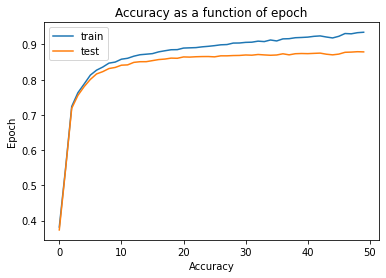

Finished in 50 epochs, final test accuracy = 0.879


In [ ]:
model = MLPV2(acts=[Relu, ExpLinearUnit], num_hidden_layer=2, num_units=[128, 128])
model.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test)

Epoch 0, test accuracy = 0.1
Epoch 20, test accuracy = 0.8243
Epoch 40, test accuracy = 0.8607


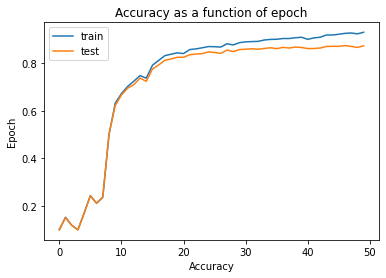

Finished in 50 epochs, final test accuracy = 0.8723


In [ ]:
model = MLPV2(acts=[Relu, ExpLinearUnit, LeakyRelu], num_hidden_layer=3, num_units=[128, 128, 128])
model.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test)

Epoch 0, test accuracy = 0.3728
Epoch 20, test accuracy = 0.8629
Epoch 40, test accuracy = 0.8674


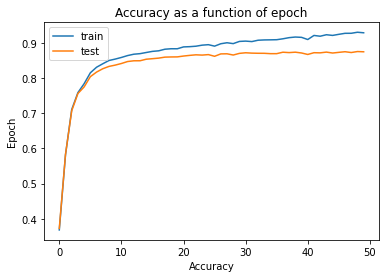

Finished in 50 epochs, final test accuracy = 0.875


In [ ]:
model = MLPV2(acts=[Relu, Tanh], num_hidden_layer=2, num_units=[128, 128])
model.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test)

Epoch 0, test accuracy = 0.1
Epoch 20, test accuracy = 0.8352
Epoch 40, test accuracy = 0.862


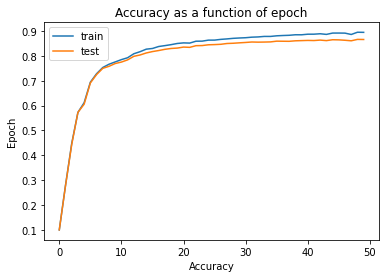

Finished in 50 epochs, final test accuracy = 0.8657


In [ ]:
model = MLPV2(acts=[Relu, Logistic], num_hidden_layer=2, num_units=[128, 128])
model.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test)

Epoch 0, test accuracy = 0.4098
Epoch 20, test accuracy = 0.8634
Epoch 40, test accuracy = 0.8748


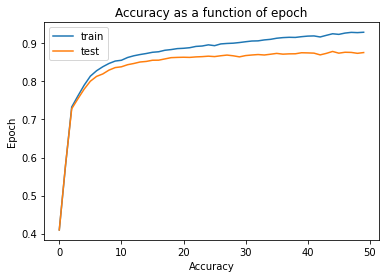

Finished in 50 epochs, final test accuracy = 0.8757


In [ ]:
model = MLPV2(acts=[ExpLinearUnit, Tanh], num_hidden_layer=2, num_units=[128, 128])
model.train(X_train, y_train, optimizer, epoch=50, batch_size=200, X_test=X_test, y_test=y_test)

Epoch 0, test accuracy = 0.1
Epoch 20, test accuracy = 0.1
Epoch 40, test accuracy = 0.1892
Epoch 60, test accuracy = 0.8271
Epoch 80, test accuracy = 0.8602


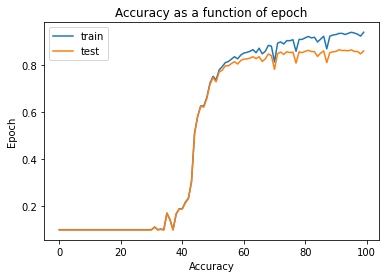

Finished in 100 epochs, final test accuracy = 0.8621


In [ ]:
model4_2 = MLPV2(acts=[ExpLinearUnit, ExpLinearUnit, Relu, Relu], num_hidden_layer=4, num_units=[128, 128, 128, 128])
model4_2.train(X_train, y_train, optimizer, epoch=100, batch_size=200, X_test=X_test, y_test=y_test)

Epoch 0, test accuracy = 0.1
Epoch 20, test accuracy = 0.1
Epoch 40, test accuracy = 0.1
Epoch 60, test accuracy = 0.6237
Epoch 80, test accuracy = 0.8423


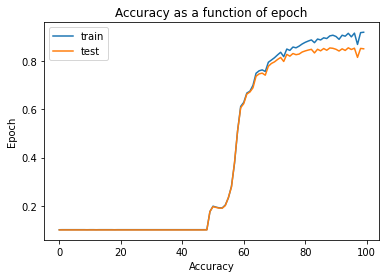

Finished in 100 epochs, final test accuracy = 0.8511


In [ ]:
model4_2 = MLPV2(acts=[ExpLinearUnit, Relu, ExpLinearUnit, Relu], num_hidden_layer=4, num_units=[128, 128, 128, 128])
model4_2.train(X_train, y_train, optimizer, epoch=100, batch_size=200, X_test=X_test, y_test=y_test)